Q-Learning for path planning and control! This algorithm will simulate a gridmap and utilize reinforcement learning to determine the best path. The path will then be traversed with PID or LQR controllers in a ROS workspace on a Turtlebot3

Credit: https://ieeexplore.ieee.org/abstract/document/6573377

In [1]:
import numpy as np
import random
from colorama import init, Fore, Back, Style
import matplotlib.pyplot as plt
import pandas as pd
from qlearner import QLearner

Let's Generate a simulation grid map class to test the Q-learner and path planning

In [2]:
class GridGenerator:
    
    # Construct grid generator class
    def __init__(self, grid_size, num_obstacles, random):
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
        self.random = random
    
    # Generate the grid
    def generate_grid(self, data):
        if self.random == True:
            # Place obstacles randomly
            obstacle_positions = random.sample(range(self.grid_size * self.grid_size), self.num_obstacles)
            for pos in obstacle_positions:
                row = pos // self.grid_size
                col = pos % self.grid_size
                self.grid[row, col] = -1  # Mark obstacle
        else: 
            # Generate grid based on given data
            obstacle_positions = data
            for pos in obstacle_positions:
                row = int(pos[0])
                col = int(pos[1])
                self.grid[row, col] = -1  # Mark obstacle
            
    # Generate the starting and stopping states
    def generate_states(self):
        states = random.sample(range(self.grid_size * self.grid_size), 2)
        for i in range(2):
            while self.grid[states[i] // self.grid_size, states[i] % self.grid_size] == -1:
                states[i] = random.choice(range(self.grid_size * self.grid_size))
        
        # Assign start and goal states to the grid
        start_row = states[0] // self.grid_size
        start_col = states[0] % self.grid_size
        self.grid[start_row, start_col] = 1
        
        target_row = states[1] // self.grid_size
        target_col = states[1] % self.grid_size
        self.grid[target_row, target_col] = 2
    
    # # Display the grid (ugly right now)
    # def print_grid(self):
    #     for row in range(self.grid_size):
    #         for col in range(self.grid_size):
    #             if self.grid[row, col] == -1:
    #                 print("██", end="")  # Print obstacle as black square
    #             elif self.grid[row, col] == 1:
    #                 print("S", end="")  # Print start as 'S'
    #             elif self.grid[row, col] == 2:
    #                 print("G", end="")  # Print goal as 'G'
    #             else:
    #                 print("  ", end=" ")  # Print empty space
    #         print()  # Move to the next line after each row



OR we can take the lidar data. Let's load it.

In [3]:
# Path to CSV file
lidar_data = 'data/pts_data.csv'

# Read the CSV file
data = pd.read_csv(lidar_data)

We need to clean the data so we aren't using hundreds of thousands of data points

In [4]:
print("Number of rows before cleaning:", len(data))

# Remove exact duplicates using Pandas
data = data.round(decimals=2)
data_cleaned = data.drop_duplicates()

# Print number of rows after cleaning
print("Number of rows after cleaning:", len(data_cleaned))

Number of rows before cleaning: 270089
Number of rows after cleaning: 24111


Now let's plot it

Data after cleaning and removing duplicates:
5757


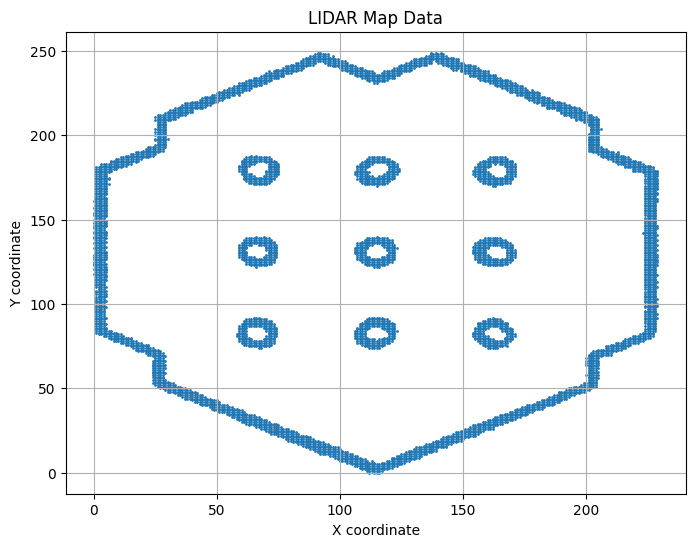

In [5]:

# Extract x and y coordinates from DataFrame
x = data_cleaned['x'].values.reshape(-1, 1)
y = data_cleaned['y'].values.reshape(-1, 1)

# Shift data to all positive for grid map indexing
x = x + np.abs(np.min(x))
y = y + np.abs(np.min(y))

# Normalize the data for creating the gridmap later
grid_size = 250 # choose grid size. Greater size means greater resolution of the obstacles
max_data = np.max([np.max(np.abs(x)),np.max(np.abs(y))])
x = np.round(x*(grid_size-1)/max_data)
y = np.round(y*(grid_size-1)/max_data)
x.astype(int)
y.astype(int)

# Concatenate x and y horizontally and remove duplicates again
data_concatenated = np.concatenate([x, y], axis=1)
data_concatenated = np.unique(data_concatenated, axis=0)
print("Data after cleaning and removing duplicates:")
print(len(data_concatenated))
x = data_concatenated[:,0]
y = data_concatenated[:,1]

# Plot the data points
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.scatter(x, y, s=1)  # s=1 sets the size of the points
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('LIDAR Map Data')
plt.grid(True)
plt.show()

Let's turn this plot into a usable gridmap

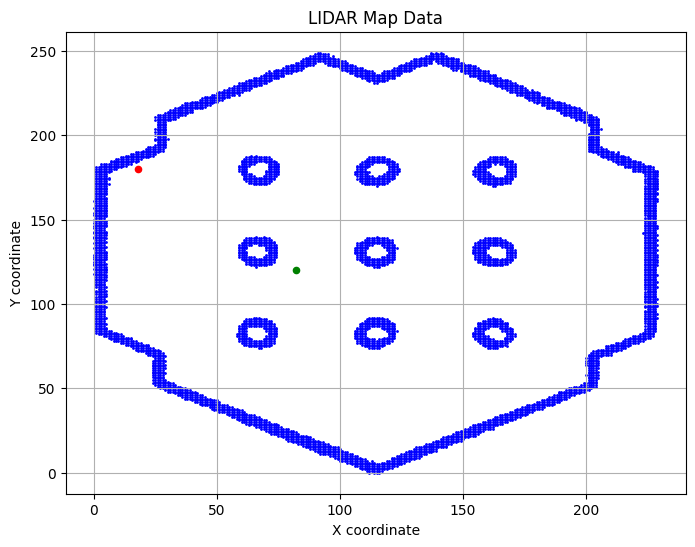

In [7]:
# Build grid object
grid_range = np.array([[np.min(x),np.max(x)], [np.min(y),np.max(y)]]) # range of grid is that of obstacles
num_obstacles = x.shape[0]

# Creating grid object and calling functions
grid_gen = GridGenerator(grid_size, num_obstacles, random = False)
grid_gen.generate_grid(data_concatenated)
grid_gen.generate_states()

## Show the created grid
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
grid_plot = np.array([])

# Separate the data into parts
grid = grid_gen.grid
grid_plot = np.array([[i, j, grid[i, j]] for i in range(grid.shape[0]) for j in range(grid.shape[1])])

obstacle_idx = grid_plot[:,2] == -1
start_idx = grid_plot[:,2] == 1
end_idx = grid_plot[:,2] == 2

obstacle_plot = grid_plot[obstacle_idx]
start_plot = grid_plot[start_idx]
end_plot = grid_plot[end_idx]

#plot the data
plt.scatter(obstacle_plot[:,0], obstacle_plot[:,1], s=1, color='blue')  # s=1 sets the size of the points
plt.scatter(start_plot[:,0], start_plot[:,1], s=20, color='red')  # s=1 sets the size of the points
plt.scatter(end_plot[:,0], end_plot[:,1], s=20, color='green')  # s=1 sets the size of the points
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('LIDAR Map Data')
plt.grid(True)
plt.show()

We can implement our qlearning for our path planning

In [7]:
# Generate the grid
# grid_gen = GridGenerator(30, 200)
# grid_gen.generate_grid()
# grid_gen.generate_states()

# grid_gen.print_grid()

# Get start and end points
start = tuple(np.argwhere(grid_gen.grid == 1)[0])
goal = tuple(np.argwhere(grid_gen.grid == 2)[0])

# Train Q-Learner
q_learner = QLearner(grid_gen.grid, start, goal, learning_rate=0.1, gamma=0.9, epsilon=0.1)
q_learner.run_q(episodes=100)

# Plot the path
q_learner.plot_path()
print('Blue = Start, Red = Goal')


KeyboardInterrupt: 

DDPG now

In [32]:
# Deep Deterministic Policy Gradient is a reinforcement learning algorithm for continuous state space and action space. 
# This should allow the robot to learn as it moves continuously.
# Actor-Critic models in ML are based on an actor that decides the best action at a state and a critic that evaluates the actions taken by the actor and gives it feedback.

# This program has two operations: training and testing
# Training: Collect data from environment, update actor and critic networks using the Bellman equation
# Testing: Use the trained networks to select best actions based on the current state and assess the performance without network updating

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import gym

# Create the actor and critic models
# Actor is responsible for mapping states to actions in continuous space. (Maximize the expected Q values??)
def create_actor(state_dim, action_dim, action_bound):
    
    # create input layer for the actor network
    inputs = layers.Input(shape=(state_dim,)) 
    
    # add a fully connected (dense) layer with ReLu activation function for nonlinearity. Input to this layer is the inputs. Number of units is inspired by Lillicrap et al.
    out = layers.Dense(400, activation="relu")(inputs)
    
    # add another dense layer
    out = layers.Dense(300, activation="relu")(out)
    
    # add a final layer with tanh activation function to map between -1 and 1 (bound the continuous action)    
    outputs = layers.Dense(action_dim, activation="tanh")(out) 
    outputs = outputs * action_bound # Scale the actions to a realizable output for the robot within the robot's action bound
    
    # Create the model
    model = tf.keras.Model(inputs, outputs)
    return model

# Building the critic to critique the actor. Want to minimize the difference between predicted q values and actual q values.
def create_critic(state_dim, action_dim):
    # create input layer for the critic state network
    state_input = layers.Input(shape=(state_dim,))
    
    # add a fully connected (dense) layer with ReLu activation function for nonlinearity. Input to this layer is the inputs.
    state_out = layers.Dense(16, activation="relu")(state_input)
    
    # add another dense layer
    state_out = layers.Dense(32, activation="relu")(state_out)

    # make a separate network for action space
    action_input = layers.Input(shape=(action_dim,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Combine the model outputs. This is where the Q-values will come from
    concat = layers.Concatenate()([state_out, action_out])

    # Process the concatenated data
    out = layers.Dense(256, activation="relu")(concat)
    
    # Output Q-value (reward for a state-action pair) with a linear activation function
    outputs = layers.Dense(1)(out)

    # Save the model
    model = tf.keras.Model([state_input, action_input], outputs)
    return model

# Hyperparameters
gamma = 0.99 # importance of future rewards (discount factor)
tau = 0.005 # sorta like learning rate
buffer_capacity = 50000
batch_size = 64 # training in batches instead of individual samples

# Initialize the actor and critic models
state_dim = 3  # Pendulum state dimension
action_dim = 2  # Pendulum action dimension
max_linear_velocity = 0.22  # Maximum linear velocity (m/s)
max_angular_velocity = 2.84  # Maximum angular velocity (rad/s)
action_bound = np.array([max_linear_velocity, max_angular_velocity])

actor_model = create_actor(state_dim, action_dim, action_bound)
critic_model = create_critic(state_dim, action_dim)
target_actor = create_actor(state_dim, action_dim, action_bound)
target_critic = create_critic(state_dim, action_dim)

# Copy weights from the actor and critic to their target counterparts
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Optimizers initialization - these are for updating the weights in the DNN models (like gradient descent)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Experience replay buffer - storage for actions, states, rewards
class ReplayBuffer:
    def __init__(self, capacity, state_dim, action_dim):
        self.capacity = capacity
        self.state_buffer = np.zeros((capacity, state_dim))
        self.action_buffer = np.zeros((capacity, action_dim))
        self.reward_buffer = np.zeros((capacity, 1))
        self.next_state_buffer = np.zeros((capacity, state_dim))
        self.buffer_counter = 0

    # Record the states, actions, and rewards taken by the robot. Obs_tuple contains state, action, reward, next_state in this order.
    def record(self, obs_tuple):
        index = self.buffer_counter % self.capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1

    # Get the obs_tuple
    def sample(self):
        record_range = min(self.buffer_counter, self.capacity)
        batch_indices = np.random.choice(record_range, batch_size) # Randomly select indices to sample
        state_batch = self.state_buffer[batch_indices]
        action_batch = self.action_buffer[batch_indices]
        reward_batch = self.reward_buffer[batch_indices]
        next_state_batch = self.next_state_buffer[batch_indices]
        return state_batch, action_batch, reward_batch, next_state_batch

buffer = ReplayBuffer(buffer_capacity, state_dim, action_dim)

# Soft update of target network weights - the target network is an offline model that updates towards the online model according to set value of tau, the adjustment rate. 
# The slower adjustment rate stabilizes the training compared to the online model.
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

# Policy function - inputs: the current state space and noise which encourages exploration
def policy(state, noise_object):
    # give input to the actor model to get the action and flatten it
    sampled_actions = tf.squeeze(actor_model(state))
    
    # Generate noise
    noise = noise_object()
    
    # Convert the sampled actions to numpy and add noise
    sampled_actions = sampled_actions.numpy() + noise
    
    # Ensure the action bounds are met
    legal_action = np.clip(sampled_actions, -action_bound, action_bound)
    
    # return the action in proper form
    return [np.squeeze(legal_action)]

# Training process
@tf.function # Decorator that converts python function into Tensorflow graph to speedup computations
def update(state_batch, action_batch, reward_batch, next_state_batch): # This function is a forward propagation followed by a backward propagation gradient update for both actor and critic updates
    
    # CRITIC update
    with tf.GradientTape() as tape:
        
        # Actions predicted by the target actor network for the next state
        target_actions = target_actor(next_state_batch, training=True)
        
        # Bellman equation update Q-value
        y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training=True)
        
        # Q-value predicated by the critic
        critic_value = critic_model([state_batch, action_batch], training=True)
        
        # Loss between the critic value and the target value
        critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

    # Update the critic gradient
    critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
    
    # Apply the gradients to the critic optimizer
    critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))

    # ACTOR update
    with tf.GradientTape() as tape:
        # Actions predicted by the actor network for the current state
        actions = actor_model(state_batch, training=True)
        
        # Actions predicted by the actor network for the current state
        critic_value = critic_model([state_batch, actions], training=True)
        
        # Loss is the critic value?
        actor_loss = -tf.math.reduce_mean(critic_value)

    # Update the actor gradient
    actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
    
    # Apply the gradients to the actor optimizer
    actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

# Main training loop
env = gym.make("Pendulum-v1")  # create an instance of pendulum environment 

# reward in each episode and reward overall tracking
ep_reward_list = []
avg_reward_list = []

# Noise for exploration using OU noise algorithm
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mean)

std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(action_dim), std_deviation=std_dev * np.ones(action_dim))

# Training loop
for ep in range(1000):
    prev_state = env.reset()  # Reset the environment for each episode
    episodic_reward = 0  # Reset the reward to 0 for each episode

    while True:
        flattened_state = np.array(prev_state[0]).flatten()

        # Convert to TensorFlow tensor and expand dimensions if necessary
        tf_prev_state = tf.convert_to_tensor(flattened_state, dtype=tf.float32)
        if len(tf_prev_state.shape) == 1:
            tf_prev_state = tf.expand_dims(tf_prev_state, 0) # basically a reshape, flattening the tensor

        # Choose an action based on the policy
        action = policy(tf_prev_state, ou_noise)
        
        # Execute the action and note the state, reward, whether or not the episode is done, and other info
        state, reward, done, info, extra_info = env.step(action)
        
        # Record experience in the replay buffer
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        # If the buffer has enough samples, update the networks
        if buffer.buffer_counter > batch_size:
            states, actions, rewards, next_states = buffer.sample()
            update(states, actions, rewards, next_states)
            update_target(target_actor.variables, actor_model.variables, tau)
            update_target(target_critic.variables, critic_model.variables, tau)

        # Update to next state
        prev_state = state

        # Break if the episode is done
        if done:
            break

    ep_reward_list.append(episodic_reward)
    avg_reward = np.mean(ep_reward_list[-40:])
    avg_reward_list.append(avg_reward)
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))

env.close()



/home/jblevins32/anaconda3/envs/myenv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/jblevins32/anaconda3/envs/myenv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/jblevins32/anaconda3/envs/myenv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:252: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'numpy.ndarray'>
  logger.warn(


KeyboardInterrupt: 